# Introduction and Motivation
This notebook aims to detect abnormal approach trajectories for aircraft landing at EPWA airport using unsupervised clustering techniques. By analyzing the 'time in area' feature and other relevant flight parameters, we seek to identify outlier flights that may indicate anomalies or unusual operational patterns.

**Motivation:**
- Improve the safety and efficiency of airport operations by detecting atypical approaches.
- Provide insights into flight behavior using data-driven methods.
- Compare different clustering algorithms (DBSCAN, HDBSCAN, K-Means, K-Medoids, Agglomerative Clustering) and evaluate their effectiveness for anomaly detection in this context.

The following sections will guide you through data preparation, exploratory analysis, clustering experiments, and evaluation of results.

# Time in area
We will use the time in area to determine abnormal approach trajectories in our dataset.

In [7]:
# Import required libraries
import os
from traffic.core import Traffic, Flight
from traffic.data import airports
from traffic.data import opensky
from cartes.crs import EPSG_2180
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from matplotlib.dates import DateFormatter
import time
import plotly.express as px
import re
from bs4 import BeautifulSoup
import plotly.graph_objects as go
import seaborn as sns
import pandas as pd
from sklearn.metrics import silhouette_score
import ruptures as rpt
import matplotlib.gridspec as gridspec
import hdbscan
from anomatools.models import kNNO
from tqdm import tqdm

# Data Loading and Preprocessing
In this section, we load the trajectory data for aircraft approaching EPWA airport and perform initial preprocessing steps. The main data source consists of flight trajectory files, which are organized by runway. We extract relevant features, such as the 'time in area' for each flight, and prepare the data for further analysis.

**Key steps:**
- Load flight trajectory data from the dataset directory.
- Combine data from all runways into a single dataset.
- Extract features such as ICAO24 identifier, date, and time spent in the defined area.
- Standardize the feature(s) for clustering.

The following code cells implement these steps.

In [2]:
# Set the path to the directory containing trajectory files
trajectories_folder = '../datasetsV2/dataset_specific_callsigns/trajectories'

In [3]:
def extract_flights_per_runway(callsign=None):
    """
    Extracts flights for each runway from the specified directory. Optionally filters by callsign.
    Returns a dictionary mapping runway numbers to Traffic objects.
    """
    runway_traffic = {}
    for subfolder in os.listdir(trajectories_folder):
        subfolder_path = os.path.join(trajectories_folder, subfolder)
        if os.path.isdir(subfolder_path):
            flights = []
            for filename in os.listdir(subfolder_path):
                if callsign and callsign in filename or not callsign:
                    file_path = os.path.join(subfolder_path, filename)
                    flights.append(Flight.from_file(file_path))
            if flights:
                runway_number = ''.join(filter(str.isdigit, subfolder))
                runway_traffic[int(runway_number)] = Traffic.from_flights(flights)
    return runway_traffic

In [4]:
# Load and combine all flights from all runways into a single Traffic object
traffic = extract_flights_per_runway()
all_flights = []
for runway, flights in traffic.items():
    for flight in flights:
        all_flights.append(flight)
traffic = Traffic.from_flights(all_flights)

# Add additional time-based features for each flight
traffic = traffic.aircraft_data()
traffic = traffic.assign(
    quarter=lambda df: df.timestamp.dt.quarter,
    month=lambda df: df.timestamp.dt.month,
    day=lambda df: df.timestamp.dt.day,
    hour=lambda df: df.timestamp.dt.hour,
    weekday=lambda df: df.timestamp.dt.weekday,
)

# Exploratory Data Analysis (EDA)
In this section, we explore the main characteristics of the dataset. We visualize the distribution of the 'time in area' feature and check for potential outliers or interesting patterns. This helps us understand the data before applying clustering algorithms.

**Key steps:**
- Visualize the distribution of 'time in area' for all flights.
- Identify any apparent anomalies or clusters visually.
- Summarize key statistics of the feature(s).

In [5]:
# Prepare lists to store extracted features for each flight
times_in_area = []
icao24s = []
dates = []
trajectories_starts = []
trajectories_stops = []

In [8]:
# Extract 'time in area' and other features for each flight
for flight in tqdm(traffic):
    df = flight.data
    if df is not None and not df.empty:
        time_in_area = (df.timestamp.max() - df.timestamp.min()).total_seconds()
        times_in_area.append(time_in_area)
        icao24s.append(flight.icao24)
        dates.append(df.timestamp.min().date())
        trajectories_starts.append(flight.start)
        trajectories_stops.append(flight.stop)

100%|██████████| 6744/6744 [00:13<00:00, 508.80it/s]


In [9]:
# Convert to numpy array and standardize the 'time in area' feature for clustering and EDA
X = np.array(times_in_area).reshape(-1, 1)
X_scaled = StandardScaler().fit_transform(X)

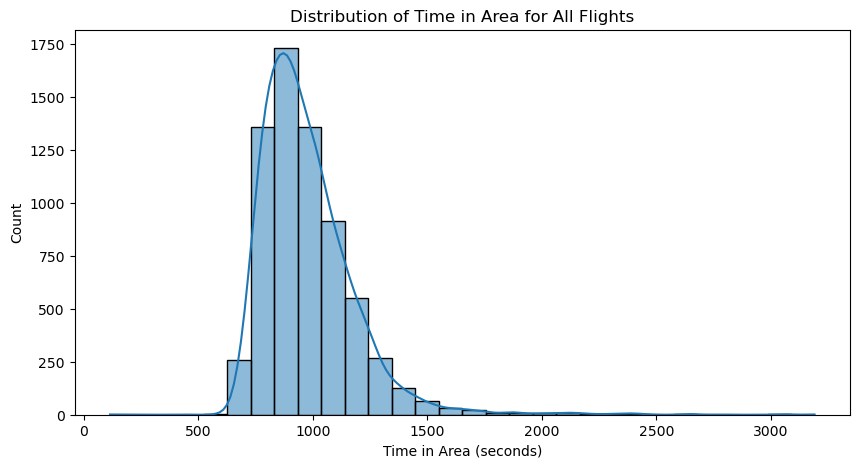

count    6744.000000
mean      976.511714
std       209.075323
min       115.000000
25%       837.000000
50%       936.000000
75%      1070.000000
max      3191.000000
Name: time_in_area, dtype: float64


In [15]:
# Create a DataFrame for easier analysis
eda_df = pd.DataFrame({
    'icao24': icao24s,
    'start': trajectories_starts,
    'stop': trajectories_stops,
    'date': dates,
    'time_in_area': times_in_area
})

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(eda_df['time_in_area'], bins=30, kde=True)
plt.xlabel('Time in Area (seconds)')
plt.title('Distribution of Time in Area for All Flights')
plt.show()

# Show basic statistics
print(eda_df['time_in_area'].describe())

# Statistical Analysis

In [ ]:
# Select trajectories with 'time_in_area' below the 5th percentile and above the 95th percentile
lower_percentile = eda_df['time_in_area'].quantile(0.01)
upper_percentile = eda_df['time_in_area'].quantile(0.99)

below = eda_df[eda_df['time_in_area'] < lower_percentile]
above = eda_df[eda_df['time_in_area'] > upper_percentile]

print(f"Number of trajectories below 1th percentile: {len(below)}")
print(f"Number of trajectories above 99th percentile: {len(above)}")

Number of trajectories below 5th percentile: 66
Number of trajectories above 95th percentile: 68


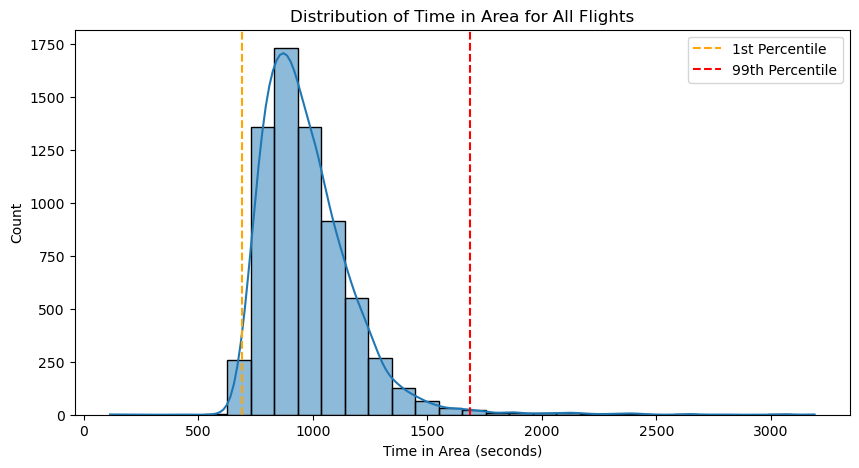

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(eda_df['time_in_area'], bins=30, kde=True)
plt.axvline(lower_percentile, color='orange', linestyle='--', label='1st Percentile')
plt.axvline(upper_percentile, color='red', linestyle='--', label='99th Percentile')
plt.xlabel('Time in Area (seconds)')
plt.title('Distribution of Time in Area for All Flights')
plt.legend()
plt.show()

Let's plot the shortest and longest trajectories below lower percentile

In [18]:
# Find the shortest and longest trajectory below the lower percentile
if not below.empty:
    shortest_idx = below['time_in_area'].idxmin()
    longest_idx = below['time_in_area'].idxmax()
    shortest_traj = below.loc[shortest_idx]
    longest_traj = below.loc[longest_idx]
    print("Shortest trajectory below lower percentile:")
    print(shortest_traj)
    print("\nLongest trajectory below lower percentile:")
    print(longest_traj)
else:
    print("No trajectories found below the lower percentile.")

Shortest trajectory below lower percentile:
icao24                             484442
start           2022-09-17 00:00:03+00:00
stop            2022-09-17 00:01:58+00:00
date                           2022-09-17
time_in_area                        115.0
Name: 773, dtype: object

Longest trajectory below lower percentile:
icao24                             48ad00
start           2022-12-19 20:52:25+00:00
stop            2022-12-19 21:03:57+00:00
date                           2022-12-19
time_in_area                        692.0
Name: 2131, dtype: object


In [20]:
shortest_traj_data = traffic.query(f"icao24 == '{shortest_traj['icao24']}' and timestamp >= '{shortest_traj['start']}' and timestamp <= '{shortest_traj['stop']}'")
longest_traj_data = traffic.query(f"icao24 == '{longest_traj['icao24']}' and timestamp >= '{longest_traj['start']}' and timestamp <= '{longest_traj['stop']}'")

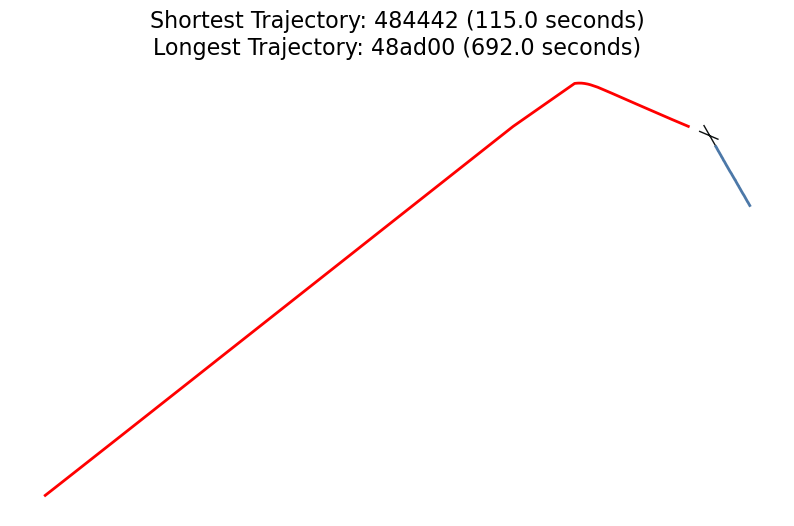

In [21]:
with plt.style.context("traffic"):

    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))

    airports["EPWA"].plot(ax, footprint=False, runways=dict(linewidth=1))
    shortest_traj_data.plot(ax, linewidth=2)
    longest_traj_data.plot(ax, linewidth=2, color='red')
    
    ax.set_title(f"Shortest Trajectory: {shortest_traj['icao24']} ({shortest_traj['time_in_area']} seconds)\n"
                 f"Longest Trajectory: {longest_traj['icao24']} ({longest_traj['time_in_area']} seconds)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)
    plt.show()

We see that the shortest trajectory is clipped trajectory, but the longest trajectory is a normal trajectory. Therefore we will not classify trajectories below 1st percentile as anomalies. 

Now we can look at the shortest and longest trajectories above 99th percentile.

In [23]:
if not above.empty:
    shortest_idx = above['time_in_area'].idxmin()
    longest_idx = above['time_in_area'].idxmax()
    shortest_traj = above.loc[shortest_idx]
    longest_traj = above.loc[longest_idx]
    print("Shortest trajectory above upper percentile:")
    print(shortest_traj)
    print("\nLongest trajectory above upper percentile:")
    print(longest_traj)
else:
    print("No trajectories found above the upper percentile.")

Shortest trajectory above upper percentile:
icao24                             48ada4
start           2022-06-07 19:22:51+00:00
stop            2022-06-07 19:50:59+00:00
date                           2022-06-07
time_in_area                       1688.0
Name: 4451, dtype: object

Longest trajectory above upper percentile:
icao24                             48ada5
start           2022-01-30 18:04:16+00:00
stop            2022-01-30 18:57:27+00:00
date                           2022-01-30
time_in_area                       3191.0
Name: 4558, dtype: object


In [24]:
shortest_traj_data = traffic.query(f"icao24 == '{shortest_traj['icao24']}' and timestamp >= '{shortest_traj['start']}' and timestamp <= '{shortest_traj['stop']}'")
longest_traj_data = traffic.query(f"icao24 == '{longest_traj['icao24']}' and timestamp >= '{longest_traj['start']}' and timestamp <= '{longest_traj['stop']}'")

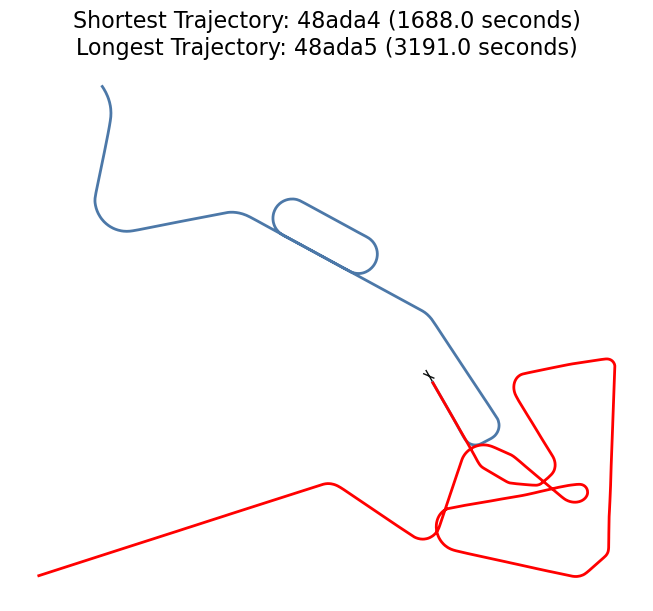

In [25]:
with plt.style.context("traffic"):

    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))

    airports["EPWA"].plot(ax, footprint=False, runways=dict(linewidth=1))
    shortest_traj_data.plot(ax, linewidth=2)
    longest_traj_data.plot(ax, linewidth=2, color='red')
    
    ax.set_title(f"Shortest Trajectory: {shortest_traj['icao24']} ({shortest_traj['time_in_area']} seconds)\n"
                 f"Longest Trajectory: {longest_traj['icao24']} ({longest_traj['time_in_area']} seconds)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)
    plt.show()

Based on plot we can classify trajectories as abnormal if they are above 99th percentile. We can also use the 95th percentile as a threshold, but we will not classify trajectories below 1st percentile as anomalies.

In [26]:
# Select trajectories with 'time_in_area' below the 5th percentile and above the 95th percentile
upper_percentile = eda_df['time_in_area'].quantile(0.95)

above = eda_df[eda_df['time_in_area'] > upper_percentile]

print(f"Number of trajectories above 95th percentile: {len(above)}")

Number of trajectories above 95th percentile: 337


Let's look at shortest trajectory above 95th percentile.

In [ ]:
shortest_idx = above['time_in_area'].idxmin()
shortest_traj = above.loc[shortest_idx]
print("Shortest trajectory above upper percentile:")
print(shortest_traj)

Shortest trajectory above upper percentile:
icao24                             489329
start           2022-01-29 17:59:22+00:00
stop            2022-01-29 18:21:18+00:00
date                           2022-01-29
time_in_area                       1316.0
Name: 1556, dtype: object


In [28]:
shortest_traj_data = traffic.query(f"icao24 == '{shortest_traj['icao24']}' and timestamp >= '{shortest_traj['start']}' and timestamp <= '{shortest_traj['stop']}'")

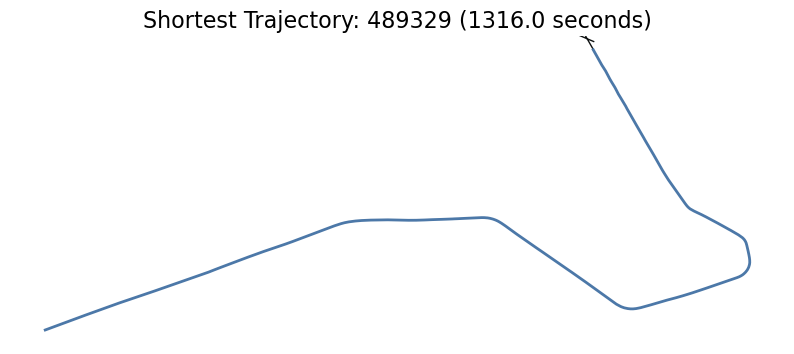

In [29]:
with plt.style.context("traffic"):

    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))

    airports["EPWA"].plot(ax, footprint=False, runways=dict(linewidth=1))
    shortest_traj_data.plot(ax, linewidth=2)
    
    ax.set_title(f"Shortest Trajectory: {shortest_traj['icao24']} ({shortest_traj['time_in_area']} seconds)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)
    plt.show()

Take all trajectories above 95th percentile.

In [ ]:
threshold_99 = eda_df['time_in_area'].quantile(0.99)
trajectories_above_99 = eda_df[eda_df['time_in_area'] > threshold_99]
print(f"Number of trajectories above 99th percentile: {len(trajectories_above_99)}")
trajectories_above_99

Number of trajectories above 99th percentile: 68


,icao24,start,stop,date,time_in_area
58,4601f9,2022-03-25 17:11:26+00:00,2022-03-25 17:55:52+00:00,2022-03-25,2666.0
79,461e14,2022-04-09 10:37:42+00:00,2022-04-09 11:06:45+00:00,2022-04-09,1743.0
304,461e1a,2022-01-15 10:45:45+00:00,2022-01-15 11:29:45+00:00,2022-01-15,2640.0
445,461e1c,2022-04-20 16:57:48+00:00,2022-04-20 17:36:54+00:00,2022-04-20,2346.0
535,461e1f,2022-02-17 11:04:11+00:00,2022-02-17 11:33:16+00:00,2022-02-17,1745.0
...,...,...,...,...,...
6269,48af00,2022-04-01 19:39:43+00:00,2022-04-01 20:19:50+00:00,2022-04-01,2407.0
6290,48af01,2022-09-23 10:45:15+00:00,2022-09-23 11:15:58+00:00,2022-09-23,1843.0
6302,48af01,2022-04-12 10:56:37+00:00,2022-04-12 11:28:28+00:00,2022-04-12,1911.0
6352,48af03,2022-02-19 11:44:25+00:00,2022-02-19 12:34:59+00:00,2022-02-19,3034.0


In [38]:
abnormal_flights = []

for flight in tqdm(traffic):
    # Check if the flight exists in trajectories_above_99 by matching icao24, start, and stop
    match = trajectories_above_99[
        (trajectories_above_99['icao24'] == flight.icao24) &
        (trajectories_above_99['start'] == flight.start) &
        (trajectories_above_99['stop'] == flight.stop)
    ]
    if not match.empty:
        abnormal_flights.append(flight)

100%|██████████| 6744/6744 [00:18<00:00, 369.37it/s]


In [39]:
len(abnormal_flights)

68

In [42]:
abnormal_time_in_area_traffic = Traffic.from_flights(abnormal_flights)

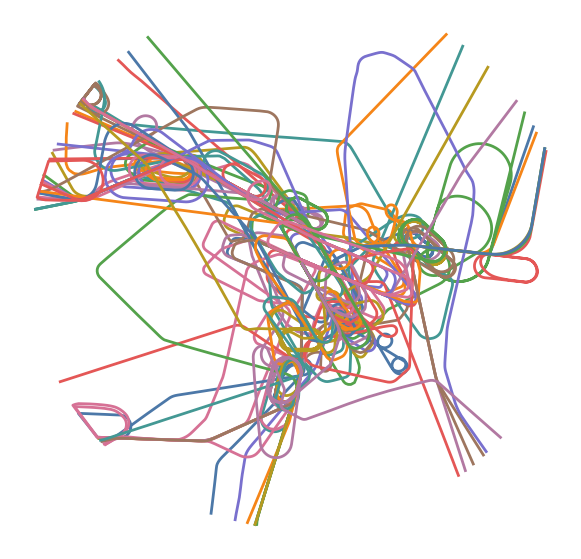

In [ ]:
with plt.style.context("traffic"):

    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))

    airports["EPWA"].plot(ax, footprint=False, runways=dict(linewidth=1))
    
    for flight in abnormal_time_in_area_traffic:
        flight.plot(ax, linewidth=2, label=flight.icao24)
    
    plt.show()

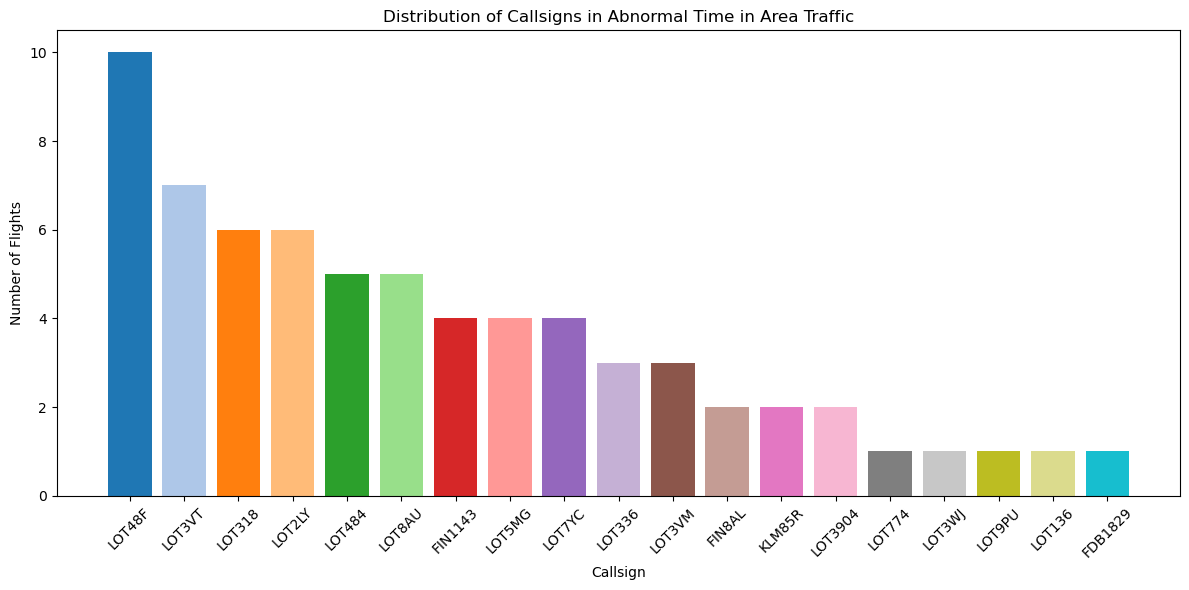

In [45]:
# Plot the distribution of callsigns in abnormal_time_in_area_traffic, sorted and colored
callsign_counts = {}

for flight in abnormal_time_in_area_traffic:
    if flight.callsign not in callsign_counts:
        callsign_counts[flight.callsign] = 0
    callsign_counts[flight.callsign] += 1

# Sort callsigns by count descending
sorted_callsigns = sorted(callsign_counts.items(), key=lambda x: x[1], reverse=True)
callsigns, counts = zip(*sorted_callsigns)

# Use a colormap for colors
colors = plt.cm.tab20.colors
bar_colors = [colors[i % len(colors)] for i in range(len(callsigns))]

plt.figure(figsize=(12, 6))
plt.bar(callsigns, counts, color=bar_colors)
plt.xlabel('Callsign')
plt.ylabel('Number of Flights')
plt.title('Distribution of Callsigns in Abnormal Time in Area Traffic')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

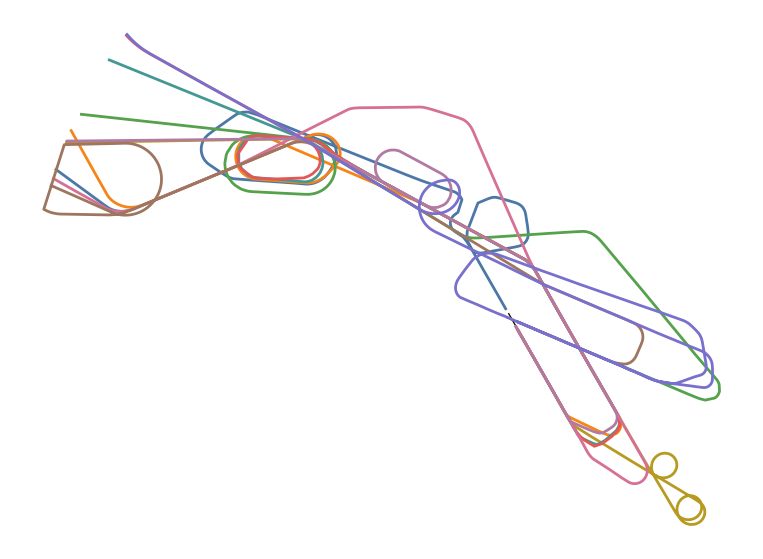

In [48]:
with plt.style.context("traffic"):

    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))

    airports["EPWA"].plot(ax, footprint=False, runways=dict(linewidth=1))
    
    for flight in abnormal_time_in_area_traffic:
        if flight.callsign == 'LOT48F':
            flight.plot(ax, linewidth=2, label=flight.icao24)
    
    plt.show()

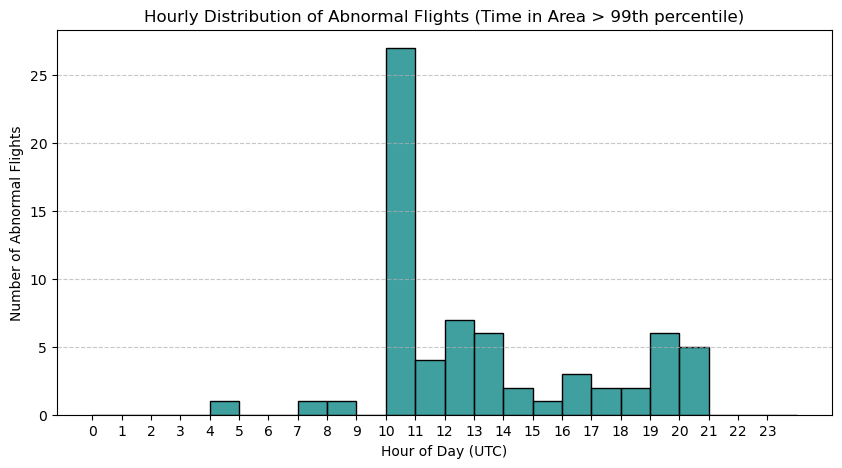

In [58]:
# Extract the hour from the start time of each abnormal flight
abnormal_hours = [flight.start.hour for flight in abnormal_time_in_area_traffic]

plt.figure(figsize=(10, 5))
sns.histplot(abnormal_hours, bins=range(0, 25), kde=False, color='teal', edgecolor='black')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Number of Abnormal Flights')
plt.title('Hourly Distribution of Abnormal Flights (Time in Area > 99th percentile)')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We see that the most of abnormal trajectories appears at 10:00. It can be caused that at this time traffic is the highest and aircrafts are waiting for landing. We have shown in another notebook that traffic at this time is the highest.

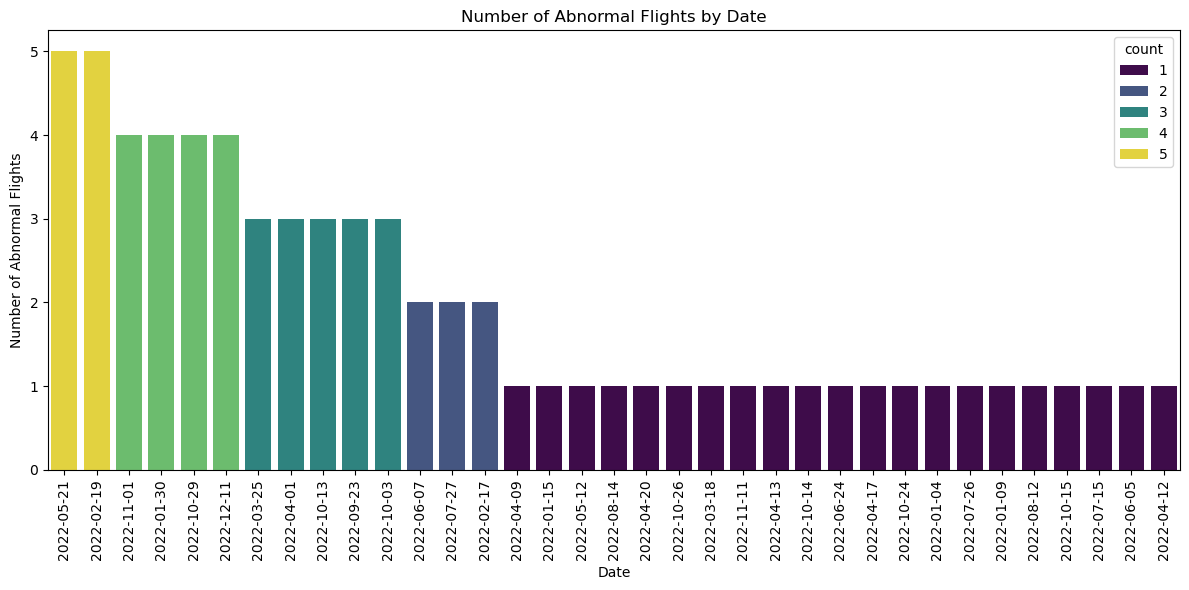

In [53]:
day_counts = {}
for flight in abnormal_time_in_area_traffic:
    day = flight.start.date()
    if day not in day_counts:
        day_counts[day] = 0
    day_counts[day] += 1
# Convert day_counts to a DataFrame for easier plotting
day_counts_df = pd.DataFrame(list(day_counts.items()), columns=['date', 'count'])
day_counts_df['date'] = pd.to_datetime(day_counts_df['date'])
day_counts_df_sorted = day_counts_df.sort_values('count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='date', y='count', data=day_counts_df_sorted, palette='viridis', hue='count')
plt.xlabel('Date')
plt.ylabel('Number of Abnormal Flights')
plt.title('Number of Abnormal Flights by Date')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [55]:
selected_date = pd.Timestamp("2022-05-21").date()
abnormal_flights_at_selected_date = [flight for flight in abnormal_time_in_area_traffic if flight.start.date() == selected_date]

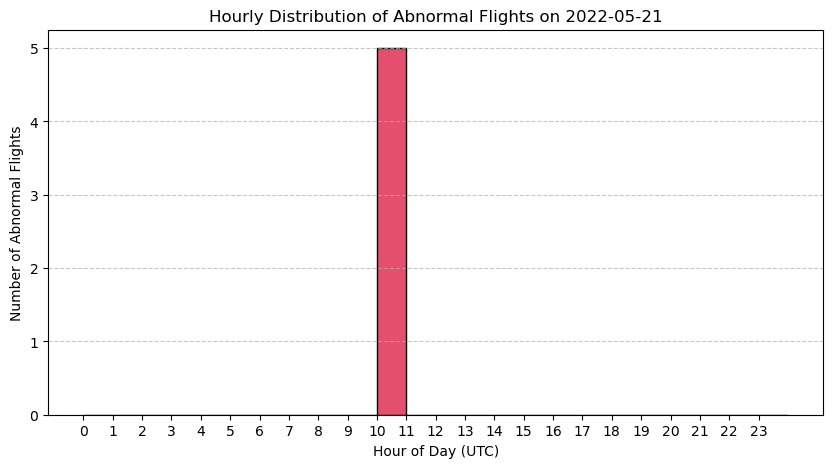

In [56]:
# Extract start times (in UTC) for abnormal flights on the selected date
hours = [flight.start.hour for flight in abnormal_flights_at_selected_date]

plt.figure(figsize=(10, 5))
sns.histplot(hours, bins=range(0, 25), kde=False, color='crimson', edgecolor='black')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Number of Abnormal Flights')
plt.title(f'Hourly Distribution of Abnormal Flights on {selected_date}')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We see that all anomalies was at the same time, so we can look at the trajectories.

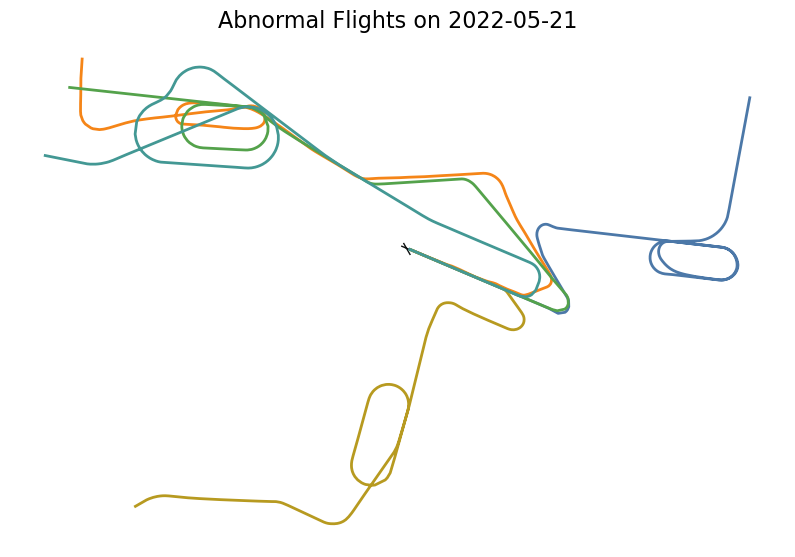

In [57]:
with plt.style.context("traffic"):

    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))

    airports["EPWA"].plot(ax, footprint=False, runways=dict(linewidth=1))
    for flight in abnormal_flights_at_selected_date:
        flight.plot(ax, linewidth=2, label=flight.icao24)
        
    ax.set_title(f"Abnormal Flights on {selected_date}")
    plt.show()    

We see that aircrafts are in holding pattern, they are waiting for landing. That can be caused by some situation on the runway e.g. collision with birds of another aircraft landing before or failure on the runway. Let's save this trajectories to the file.

In [59]:
abnormal_time_in_area_traffic.to_parquet('abnormal_time_in_area_traffic.parquet')

In the next section, we will test DBSCAN clustering and show plot that allows to analyze abnormal trajectories.

# DBSCAN Clustering
In this section, we apply the DBSCAN clustering algorithm to the standardized 'time in area' feature. DBSCAN is a density-based clustering method that can identify clusters of arbitrary shape and detect outliers (noise points).
- We will start with initial parameters and visualize the results.
- Later, we will explore the effect of different parameter choices.

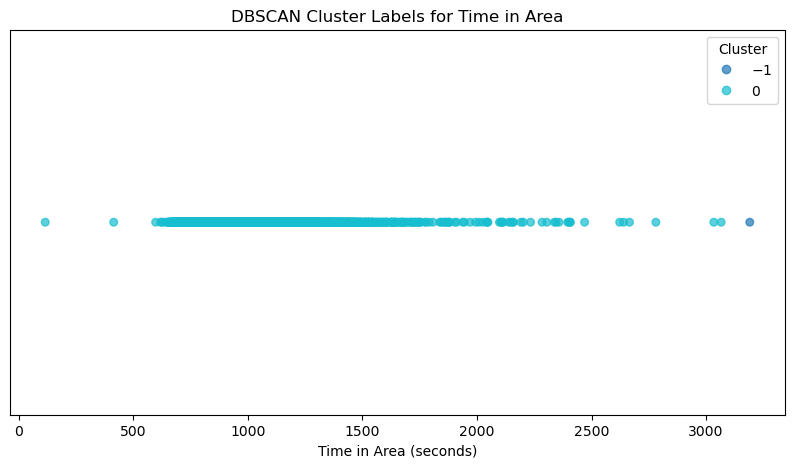

DBSCAN: clusters=1, noise points=1, silhouette=nan


In [160]:
# Initial DBSCAN parameters
eps = 1.5
min_samples = 5
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
labels = db.labels_

# Visualize clustering result
plt.figure(figsize=(10, 5))
scatter = plt.scatter(eda_df['time_in_area'], np.zeros_like(eda_df['time_in_area']), c=labels, cmap='tab10', s=30, alpha=0.7)
plt.xlabel('Time in Area (seconds)')
plt.yticks([])
plt.title('DBSCAN Cluster Labels for Time in Area')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.show()

# Print cluster statistics
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
if n_clusters > 1:
    sil_score = silhouette_score(X_scaled, labels)
else:
    sil_score = float('nan')
print(f'DBSCAN: clusters={n_clusters}, noise points={n_noise}, silhouette={sil_score:.2f}')

In [161]:
anomalies = []
for idx, label in enumerate(labels):
    if label == -1:
        anomalies.append({
            "icao24": icao24s[idx],
            "date": dates[idx],
            "time_in_area": times_in_area[idx]
        })
anomalies_df = pd.DataFrame(anomalies)
anomalies_df

,icao24,date,time_in_area
0,48ada5,2022-01-30,3191.0


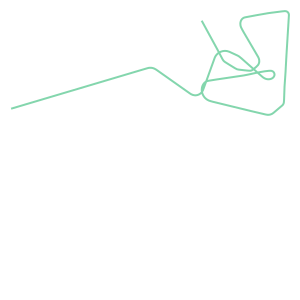

In [164]:
anomaly_flight = traffic.query("icao24 == '48ada5' and timestamp.dt.date == '2022-01-30'")["LOT3VM"]
anomaly_flight

## Weather

In [166]:
df_weather = pd.read_csv("../weather/12375-2022.csv")

In [167]:
df_weather.head()

,year,month,day,hour,temp,temp_source,rhum,rhum_source,prcp,prcp_source,...,wspd,wspd_source,wpgt,wpgt_source,pres,pres_source,cldc,cldc_source,coco,coco_source
0,2022,1,1,0,10.0,isd_lite,95,isd_lite,NaN,NaN,...,18.0,isd_lite,33.3,dwd_mosmix,1010.3,isd_lite,8.0,isd_lite,7.0,dwd_poi
1,2022,1,1,1,9.7,isd_lite,97,isd_lite,NaN,NaN,...,18.0,isd_lite,33.3,dwd_mosmix,1011.1,isd_lite,8.0,isd_lite,7.0,dwd_mosmix
2,2022,1,1,2,9.6,isd_lite,97,isd_lite,NaN,NaN,...,10.8,isd_lite,31.5,dwd_mosmix,1011.8,isd_lite,8.0,isd_lite,7.0,dwd_mosmix
3,2022,1,1,3,9.5,isd_lite,94,isd_lite,NaN,NaN,...,14.4,isd_lite,33.3,dwd_mosmix,1012.3,isd_lite,8.0,isd_lite,7.0,dwd_mosmix
4,2022,1,1,4,9.0,isd_lite,94,isd_lite,NaN,NaN,...,18.0,isd_lite,33.3,dwd_mosmix,1013.0,isd_lite,8.0,isd_lite,4.0,dwd_mosmix


## Area boundaries

In [168]:
epwa_lat = 52.165
epwa_lon = 20.967
transformer = Transformer.from_crs("EPSG:4326", "EPSG:2180", always_xy=True)
epwa_x, epwa_y = transformer.transform(epwa_lon, epwa_lat)

In [169]:
# Calculate rectangle bounds for a 100km (100,000 meters) circle around (epwa_x, epwa_y)
radius = 100_000  # meters

min_x = epwa_x - radius
max_x = epwa_x + radius
min_y = epwa_y - radius
max_y = epwa_y + radius

rectangle_bounds = (min_x, min_y, max_x, max_y)
print("Rectangle bounds (EPSG:2180):", rectangle_bounds)

Rectangle bounds (EPSG:2180): (534491.6918053627, 379479.32559454814, 734491.6918053627, 579479.3255945481)


In [170]:
min_lon, min_lat = transformer.transform(min_x, min_y, direction='INVERSE')
max_lon, max_lat = transformer.transform(max_x, max_y, direction='INVERSE')

rectangle_bounds_wgs84 = (min_lon, min_lat, max_lon, max_lat)
print("Rectangle bounds (EPSG:4326):", rectangle_bounds_wgs84)

Rectangle bounds (EPSG:4326): (19.494689910303247, 51.28094826632913, 22.498130857184055, 53.02921561178062)


In [173]:
# Unpack rectangle bounds
min_lon, min_lat, max_lon, max_lat = rectangle_bounds_wgs84

# Define rectangle corners (close the loop)
rect_lons = [min_lon, max_lon, max_lon, min_lon, min_lon]
rect_lats = [min_lat, min_lat, max_lat, max_lat, min_lat]

fig = go.Figure()

# Add 100km rectangle
fig.add_trace(go.Scattermapbox(
    lon=rect_lons,
    lat=rect_lats,
    mode='lines+markers',
    fill='toself',
    name='100km Rectangle'
))

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=5,
    mapbox_center={"lat": (min_lat + max_lat) / 2, "lon": (min_lon + max_lon) / 2},
    title="100km Rectangle around EPWA (EPSG:4326)"
)
fig.show()

## Airport traffic

In [174]:
date = pd.Timestamp("2022-01-30")

In [175]:
start_time = time.time()
arrival_traffic = opensky.history(
    start=date, 
    arrival_airport="EPWA", 
    bounds=rectangle_bounds_wgs84
)
end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

Elapsed time: 0.61 seconds


In [176]:
arrival_traffic_by_hour = {}
for flight in arrival_traffic:
    hour = flight.start.hour
    if hour not in arrival_traffic_by_hour:
        arrival_traffic_by_hour[hour] = 0
    arrival_traffic_by_hour[hour] += 1

In [177]:
start_time = time.time()
departure_traffic = opensky.history(
    start=date, 
    departure_airport="EPWA", 
    bounds=rectangle_bounds_wgs84
)
end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

Elapsed time: 0.24 seconds


In [178]:
departure_traffic_by_hour = {}

for flight in departure_traffic:
    hour = flight.start.hour
    if hour not in departure_traffic_by_hour:
        departure_traffic_by_hour[hour] = 0
    departure_traffic_by_hour[hour] += 1

## Navigation points

In [186]:
def parse_coord(coord):
    """
    Convert compact DMS string (e.g. 514037N) to decimal degrees.
    """
    match = re.match(r"(\d{2,3})(\d{2})(\d{2}(?:\.\d+)?)\s*([NSEW])", coord)
    if not match:
        return None
    deg, minute, sec, hemi = match.groups()
    dd = float(deg) + float(minute)/60 + float(sec)/3600
    if hemi in ['S', 'W']:
        dd *= -1
    return dd

In [187]:
with open("poland_navpoints.html", "r", encoding="utf-8") as f:
    soup = BeautifulSoup(f, "html.parser")

navpoints = []

for tr in soup.find_all("tr"):
    tds = tr.find_all("td")
    if len(tds) < 4:
        continue  # skip incomplete rows

    # Navpoint name
    name_span = tds[0].find("span", style=lambda s: s and "font-family" in s)
    name = name_span.text.strip() if name_span else ""

    # Coordinates
    coord_span = tds[1].find("span", style=lambda s: s and "font-family" in s)
    coords = coord_span.text.strip().replace('\xa0', ' ') if coord_span else ""
    if not coords:
        continue
    # Split into latitude and longitude
    parts = coords.split()
    if len(parts) != 2:
        continue
    lat_dd = parse_coord(parts[0])
    lon_dd = parse_coord(parts[1])
    
    # Description
    desc_span = tds[2].find("span", style=lambda s: s and "font-family" in s)
    desc = desc_span.text.strip() if desc_span else ""

    # Extra info (FRA etc.)
    extra_span = tds[3].find("span", style=lambda s: s and "font-family" in s)
    extra = extra_span.text.strip().replace('\n', ' ') if extra_span else ""

    navpoints.append({
        "name": name,
        "latitude": lat_dd,
        "longitude": lon_dd,
        "ATS route": desc,
        "remarks": extra
    })

# Example: print first 5
for n in navpoints[:1]:
    print(n)

{'name': 'ABAKU', 'latitude': 51.676944444444445, 'longitude': 19.08138888888889, 'ATS route': 'STAR EPLL, N871', 'remarks': 'FRA(I)          FRA(A): EPLL'}


In [188]:
df_navpoints = pd.DataFrame(navpoints)

transformer = Transformer.from_crs("EPSG:4326", "EPSG:2180", always_xy=True)
df_navpoints['x'], df_navpoints['y'] = transformer.transform(df_navpoints['longitude'], df_navpoints['latitude'])

min_lon, min_lat, max_lon, max_lat = anomaly_flight.bounds
df_navpoints = df_navpoints[
    (df_navpoints["longitude"] >= min_lon) & (df_navpoints["longitude"] <= max_lon) &
    (df_navpoints["latitude"] >= min_lat) & (df_navpoints["latitude"] <= max_lat)
]
df_navpoints = df_navpoints[
    df_navpoints["ATS route"].str.contains("STAR EPWA", na=False) |
    ((df_navpoints["ATS route"].isna() | (df_navpoints["ATS route"] == "")) &
     (df_navpoints["remarks"].isna() | (df_navpoints["remarks"] == "")))
]

fig = px.scatter_mapbox(
    df_navpoints, lat="latitude", lon="longitude", hover_name="name",
    zoom=6, height=700,
    mapbox_style="open-street-map"
)
fig.show()

In [189]:
anomaly_flight = anomaly_flight.compute_xy(EPSG_2180())

# Prepare the data for change point detection: stack x, y, altitude, groundspeed, vertical_rate as columns
xy = np.column_stack([
    # anomaly_flight.data.x.values,
    # anomaly_flight.data.y.values,
    anomaly_flight.data.altitude.values,
    # anomaly_flight.data.groundspeed.values,
    # anomaly_flight.data.vertical_rate.values
])
model = "rbf"
algo = rpt.Pelt(model=model).fit(xy)
bkps = algo.predict(pen=10)

## Traffic around aircraft

In [190]:
from scipy.spatial import cKDTree
from tqdm import tqdm
import numpy as np
import pandas as pd

radius = 20000  # 20 km
window = pd.Timedelta('0min')

# 1. Gather all other flights' positions into one DataFrame
other_points = []
for full_traffic in [arrival_traffic, departure_traffic]:
    for flight in full_traffic:
        if flight.callsign == anomaly_flight.callsign:
            continue
        df = flight.compute_xy(EPSG_2180()).data[['timestamp', 'x', 'y']].copy()
        other_points.append(df)
df_others = pd.concat(other_points, ignore_index=True)
df_others = df_others.sort_values('timestamp')

min_distances = []
n_in_radius = []

print("Calculating distances to other aircraft (optimized)...")
for idx, row in tqdm(anomaly_flight.data.iterrows(), total=len(anomaly_flight.data)):
    t = row['timestamp']
    x0, y0 = row['x'], row['y']
    # Select points within ±1 min
    mask = (df_others['timestamp'] >= t - window) & (df_others['timestamp'] <= t + window)
    df_window = df_others.loc[mask]
    if df_window.empty:
        min_distances.append(np.nan)
        n_in_radius.append(0)
        continue
    tree = cKDTree(df_window[['x', 'y']].values)
    dists, _ = tree.query([x0, y0], k=len(df_window), distance_upper_bound=radius)
    min_dist = np.nanmin(dists) if len(dists) > 0 else np.nan
    n_close = np.sum(dists < radius)
    min_distances.append(min_dist)
    n_in_radius.append(n_close)

print("Finished calculating distances.")
n_in_radius = np.array(n_in_radius)
min_distances = np.array(min_distances)

Calculating distances to other aircraft (optimized)...


100%|██████████| 3143/3143 [00:06<00:00, 482.92it/s]

Finished calculating distances.


## Anomaly flight analysis

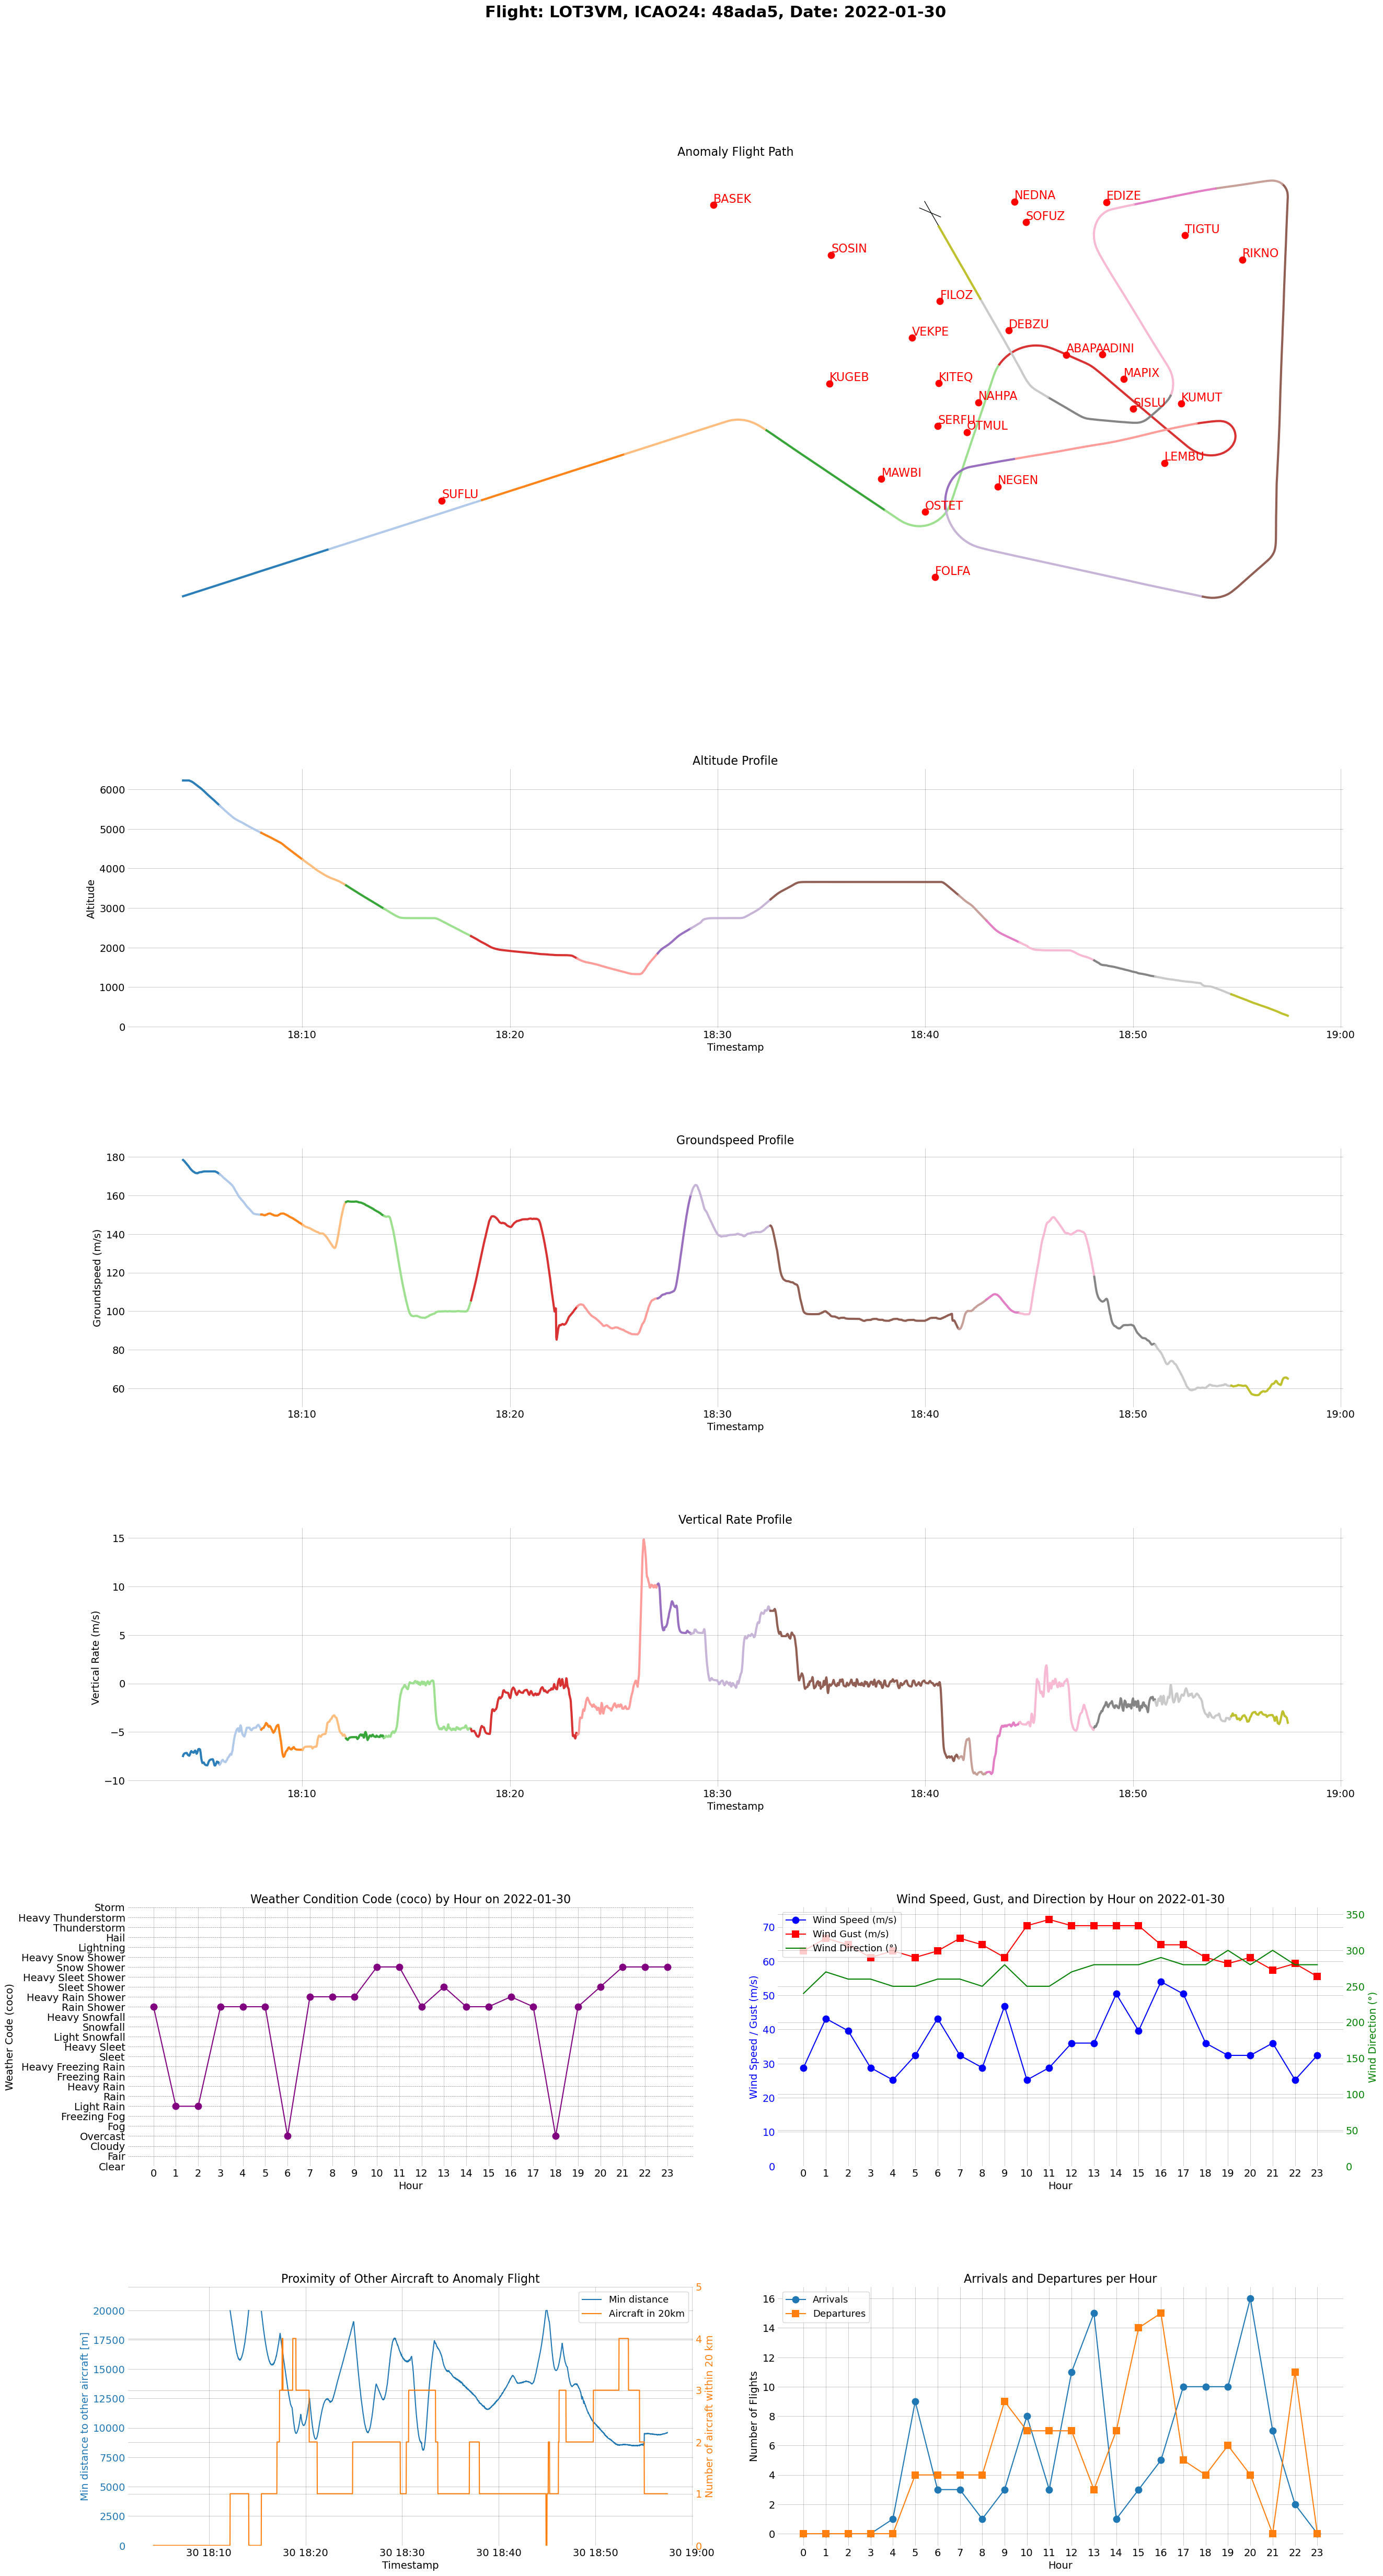

In [191]:
cmap = plt.colormaps.get_cmap("tab20")
num_colors = cmap.N

anomaly_start = anomaly_flight.data.timestamp.iloc[0]

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(30, 60))
    gs = gridspec.GridSpec(6, 2, height_ratios=[2, 1, 1, 1, 1, 1], width_ratios=[1, 1], hspace=0.4, wspace=0.15)

    # Add description box at the top of the figure
    flight_info = (
        f"Flight: {anomaly_flight.callsign}, "
        f"ICAO24: {anomaly_flight.icao24}, "
        # f"Type: {df.iloc[0]['typecode']}, "
        f"Date: {anomaly_start.date()}"
    )
    fig.suptitle(flight_info, fontsize=22, fontweight="bold", y=0.92)

    # First column
    ax_map = fig.add_subplot(gs[0, 0:2], projection=EPSG_2180())
    ax_alt = fig.add_subplot(gs[1, 0:2])
    ax_gs = fig.add_subplot(gs[2, 0:2])
    ax_vr = fig.add_subplot(gs[3, 0:2])

    # Second column
    ax_coco = fig.add_subplot(gs[4, 0])
    # Weather plot takes two rows in height
    ax_weather = fig.add_subplot(gs[4, 1])
    ax_traffic_density = fig.add_subplot(gs[5, 0])
    ax_traffic = fig.add_subplot(gs[5, 1])

    airports["EPWA"].plot(ax_map, footprint=False, runways=dict(linewidth=1))

    df = anomaly_flight.data
    x, y = anomaly_flight.compute_xy(EPSG_2180()).data.x, anomaly_flight.compute_xy(EPSG_2180()).data.y
    altitude = df.altitude
    groundspeed = df.groundspeed
    vertical_rate = df.vertical_rate
    timestamps = df.timestamp

    color = "tab:blue"
    # ax_map.plot(x, y, color=color, linewidth=3, alpha=0.95)

    prev = 0
    for i, bkp in enumerate(bkps):
        color = cmap(i % num_colors)
        ax_map.plot(x.iloc[prev:bkp], y.iloc[prev:bkp], color=color, linewidth=3, alpha=0.95)
        ax_alt.plot(timestamps.iloc[prev:bkp], altitude.iloc[prev:bkp], color=color, linewidth=3, alpha=0.95)
        ax_gs.plot(timestamps.iloc[prev:bkp], groundspeed.iloc[prev:bkp], color=color, linewidth=3, alpha=0.95)
        ax_vr.plot(timestamps.iloc[prev:bkp], vertical_rate.iloc[prev:bkp], color=color, linewidth=3, alpha=0.95)
        prev = bkp
    
    # Plot navigation points if df_navpoints is available
    if "df_navpoints" in locals() or "df_navpoints" in globals():
        ax_map.scatter(
            df_navpoints["x"], df_navpoints["y"],
            color="red", marker="o", s=80, label="Navpoints", zorder=10
        )
        for _, row in df_navpoints.iterrows():
            ax_map.text(
                row["x"], row["y"], str(row.get("name", "")),
                fontsize=16, color="red", ha="left", va="bottom", zorder=11
            )
    # ax_alt.plot(timestamps, altitude, color=color, linewidth=3, alpha=0.95)
    # ax_gs.plot(timestamps, groundspeed, color=color, linewidth=3, alpha=0.95)
    # ax_vr.plot(timestamps, vertical_rate, color=color, linewidth=3, alpha=0.95)

    # Format x-axis to show only hour:minute
    time_fmt = DateFormatter("%H:%M")
    for ax in [ax_alt, ax_gs, ax_vr]:
        ax.xaxis.set_major_formatter(time_fmt)

    # --- Weather plot for the anomaly day ---
    anomaly_start = df.iloc[0]['timestamp']
    anomaly_month = anomaly_start.month
    anomaly_day = anomaly_start.day
    df_anomaly_day = df_weather[(df_weather['month'] == anomaly_month) & (df_weather['day'] == anomaly_day)]

    max_wind = max(df_anomaly_day['wspd'].max(), df_anomaly_day['wpgt'].max())

    ax_weather.plot(df_anomaly_day['hour'], df_anomaly_day['wspd'], marker='o', color='b', label='Wind Speed (m/s)')
    ax_weather.plot(df_anomaly_day['hour'], df_anomaly_day['wpgt'], marker='s', color='r', label='Wind Gust (m/s)')
    ax_weather.set_xlabel('Hour')
    ax_weather.set_ylabel('Wind Speed / Gust (m/s)', color='b')
    ax_weather.tick_params(axis='y', labelcolor='b')
    ax_weather.set_xticks(range(0, 24))
    ax_weather.set_ylim(0, max_wind * 1.05)
    ax_weather.grid(True)

    ax_weather_dir = ax_weather.twinx()
    ax_weather_dir.plot(df_anomaly_day['hour'], df_anomaly_day['wdir'], marker='x', color='g', label='Wind Direction (°)')
    ax_weather_dir.set_ylabel('Wind Direction (°)', color='g')
    ax_weather_dir.tick_params(axis='y', labelcolor='g')
    ax_weather_dir.set_ylim(0, 360)

    lines1, labels1 = ax_weather.get_legend_handles_labels()
    lines2, labels2 = ax_weather_dir.get_legend_handles_labels()
    ax_weather.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    # --- Traffic density plot ---
    color = 'tab:blue'
    ax_traffic_density.set_xlabel('Timestamp')
    ax_traffic_density.set_ylabel('Min distance to other aircraft [m]', color=color)
    ax_traffic_density.plot(df['timestamp'], min_distances, color=color, label='Min distance')
    ax_traffic_density.tick_params(axis='y', labelcolor=color)
    ax_traffic_density.set_ylim(0, 22000)

    ax_traffic_density_n = ax_traffic_density.twinx()
    color = 'tab:orange'
    ax_traffic_density_n.set_ylabel('Number of aircraft within 20 km', color=color)
    ax_traffic_density_n.plot(df['timestamp'], n_in_radius, color=color, label='Aircraft in 20km')
    ax_traffic_density_n.tick_params(axis='y', labelcolor=color)
    ax_traffic_density_n.set_ylim(0, n_in_radius.max() + 1)
    
    lines1, labels1 = ax_traffic_density.get_legend_handles_labels()
    lines2, labels2 = ax_traffic_density_n.get_legend_handles_labels()
    ax_traffic_density.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    # --- Arrivals and Departures per hour plot ---
    hours = list(range(24))
    arrivals = [arrival_traffic_by_hour.get(h, 0) for h in hours]
    departures = [departure_traffic_by_hour.get(h, 0) for h in hours]

    ax_traffic.plot(hours, arrivals, marker='o', color='tab:blue', label='Arrivals')
    ax_traffic.plot(hours, departures, marker='s', color='tab:orange', label='Departures')
    ax_traffic.set_xlabel('Hour')
    ax_traffic.set_ylabel('Number of Flights')
    ax_traffic.set_xticks(hours)
    ax_traffic.set_title('Arrivals and Departures per Hour')
    ax_traffic.legend()
    ax_traffic.grid(True)

    # --- COCO plot ---
    coco_labels = [
        "Clear", "Fair", "Cloudy", "Overcast", "Fog", "Freezing Fog", "Light Rain", "Rain", "Heavy Rain",
        "Freezing Rain", "Heavy Freezing Rain", "Sleet", "Heavy Sleet", "Light Snowfall", "Snowfall", "Heavy Snowfall",
        "Rain Shower", "Heavy Rain Shower", "Sleet Shower", "Heavy Sleet Shower", "Snow Shower", "Heavy Snow Shower",
        "Lightning", "Hail", "Thunderstorm", "Heavy Thunderstorm", "Storm"
    ]
    ax_coco.plot(df_anomaly_day['hour'], df_anomaly_day['coco'], marker='o', linestyle='-', color='purple')
    ax_coco.set_xlabel('Hour')
    ax_coco.set_ylabel('Weather Code (coco)')
    ax_coco.set_title(f'Weather Condition Code (coco) by Hour on {anomaly_start.date()}')
    ax_coco.set_xticks(range(0, 24))
    ax_coco.set_yticks(range(1, 28))
    ax_coco.set_yticklabels(coco_labels)
    ax_coco.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Titles and labels for other plots
    ax_map.set_title("Anomaly Flight Path")
    ax_alt.set_title("Altitude Profile")
    ax_alt.set_xlabel("Timestamp")
    ax_alt.set_ylabel("Altitude")
    ax_gs.set_title("Groundspeed Profile")
    ax_gs.set_xlabel("Timestamp")
    ax_gs.set_ylabel("Groundspeed (m/s)")
    ax_vr.set_title("Vertical Rate Profile")
    ax_vr.set_xlabel("Timestamp")
    ax_vr.set_ylabel("Vertical Rate (m/s)")
    ax_weather.set_title(f"Wind Speed, Gust, and Direction by Hour on {anomaly_start.date()}")
    ax_traffic_density.set_title("Proximity of Other Aircraft to Anomaly Flight")
    
    plt.tight_layout()
    plt.show()

# DBSCAN Parameter Exploration
To better understand the sensitivity of DBSCAN to its parameters, we systematically test different values of `eps` and `min_samples`. For each combination, we report the number of clusters, number of noise points, and silhouette score.

In [212]:
# Use np.round to avoid floating point artifacts in eps values
eps_values = np.round(np.arange(0.1, 1.6, 0.1), 2)
min_samples_values = [3, 5, 10]
results = []
for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        if n_clusters > 1:
            sil_score = silhouette_score(X_scaled, labels)
        else:
            sil_score = float('nan')
        results.append({'eps': eps, 'min_samples': min_samples, 'clusters': n_clusters, 'noise': n_noise, 'silhouette': sil_score})
        print(f"eps={eps}, min_samples={min_samples} => clusters: {n_clusters}, noise: {n_noise}, silhouette: {sil_score:.2f}")

# Optionally, display results as a DataFrame
import pandas as pd
results_df = pd.DataFrame(results)
results_df

eps=0.1, min_samples=3 => clusters: 7, noise: 21, silhouette: 0.75
eps=0.1, min_samples=5 => clusters: 3, noise: 39, silhouette: 0.75
eps=0.1, min_samples=5 => clusters: 3, noise: 39, silhouette: 0.75
eps=0.1, min_samples=10 => clusters: 2, noise: 60, silhouette: 0.70
eps=0.1, min_samples=10 => clusters: 2, noise: 60, silhouette: 0.70
eps=0.2, min_samples=3 => clusters: 4, noise: 7, silhouette: 0.81
eps=0.2, min_samples=3 => clusters: 4, noise: 7, silhouette: 0.81
eps=0.2, min_samples=5 => clusters: 3, noise: 16, silhouette: 0.81
eps=0.2, min_samples=5 => clusters: 3, noise: 16, silhouette: 0.81
eps=0.2, min_samples=10 => clusters: 2, noise: 40, silhouette: 0.75
eps=0.2, min_samples=10 => clusters: 2, noise: 40, silhouette: 0.75
eps=0.3, min_samples=3 => clusters: 2, noise: 7, silhouette: 0.86
eps=0.3, min_samples=3 => clusters: 2, noise: 7, silhouette: 0.86
eps=0.3, min_samples=5 => clusters: 2, noise: 10, silhouette: 0.84
eps=0.3, min_samples=5 => clusters: 2, noise: 10, silhouette: 

eps=0.1, min_samples=3 => clusters: 7, noise: 21, silhouette: 0.75
eps=0.1, min_samples=5 => clusters: 3, noise: 39, silhouette: 0.75
eps=0.1, min_samples=5 => clusters: 3, noise: 39, silhouette: 0.75
eps=0.1, min_samples=10 => clusters: 2, noise: 60, silhouette: 0.70
eps=0.1, min_samples=10 => clusters: 2, noise: 60, silhouette: 0.70
eps=0.2, min_samples=3 => clusters: 4, noise: 7, silhouette: 0.81
eps=0.2, min_samples=3 => clusters: 4, noise: 7, silhouette: 0.81
eps=0.2, min_samples=5 => clusters: 3, noise: 16, silhouette: 0.81
eps=0.2, min_samples=5 => clusters: 3, noise: 16, silhouette: 0.81
eps=0.2, min_samples=10 => clusters: 2, noise: 40, silhouette: 0.75
eps=0.2, min_samples=10 => clusters: 2, noise: 40, silhouette: 0.75
eps=0.3, min_samples=3 => clusters: 2, noise: 7, silhouette: 0.86
eps=0.3, min_samples=3 => clusters: 2, noise: 7, silhouette: 0.86
eps=0.3, min_samples=5 => clusters: 2, noise: 10, silhouette: 0.84
eps=0.3, min_samples=5 => clusters: 2, noise: 10, silhouette: 

,eps,min_samples,clusters,noise,silhouette
0,0.1,3,7,21,0.747693
1,0.1,5,3,39,0.745263
2,0.1,10,2,60,0.701066
3,0.2,3,4,7,0.810291
4,0.2,5,3,16,0.806277
5,0.2,10,2,40,0.749803
6,0.3,3,2,7,0.857960
7,0.3,5,2,10,0.837719
8,0.3,10,2,23,0.805363
9,0.4,3,2,6,0.858165


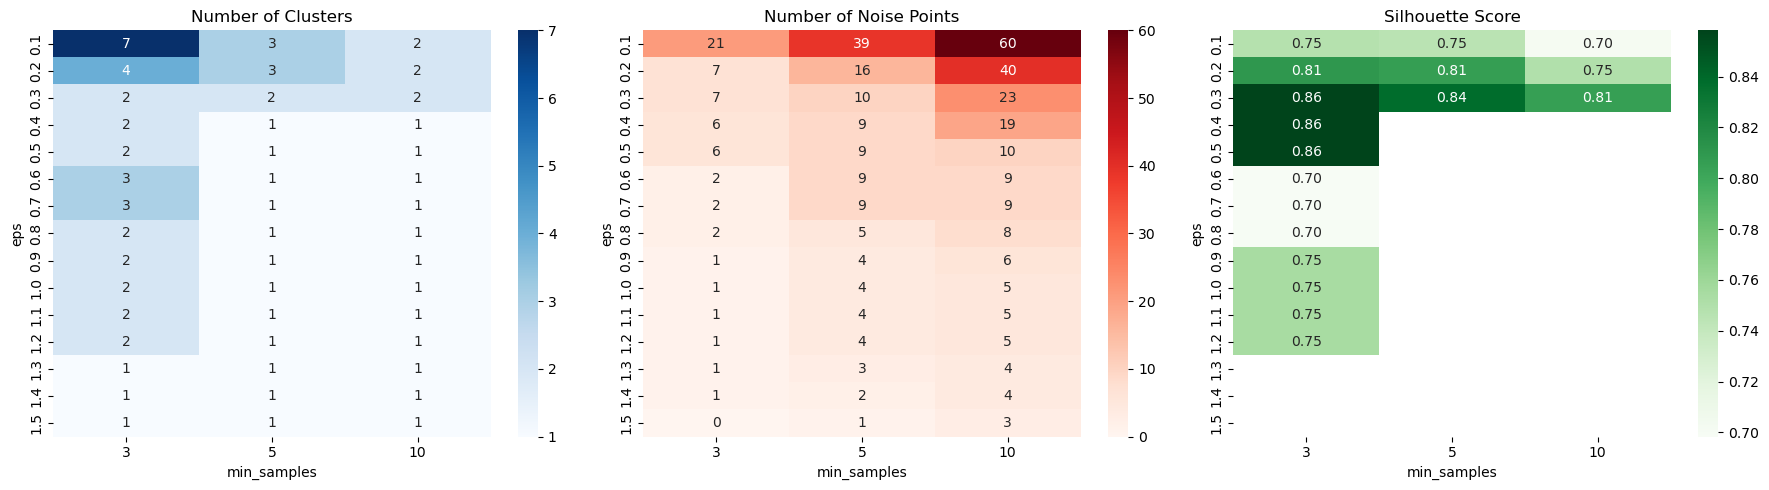

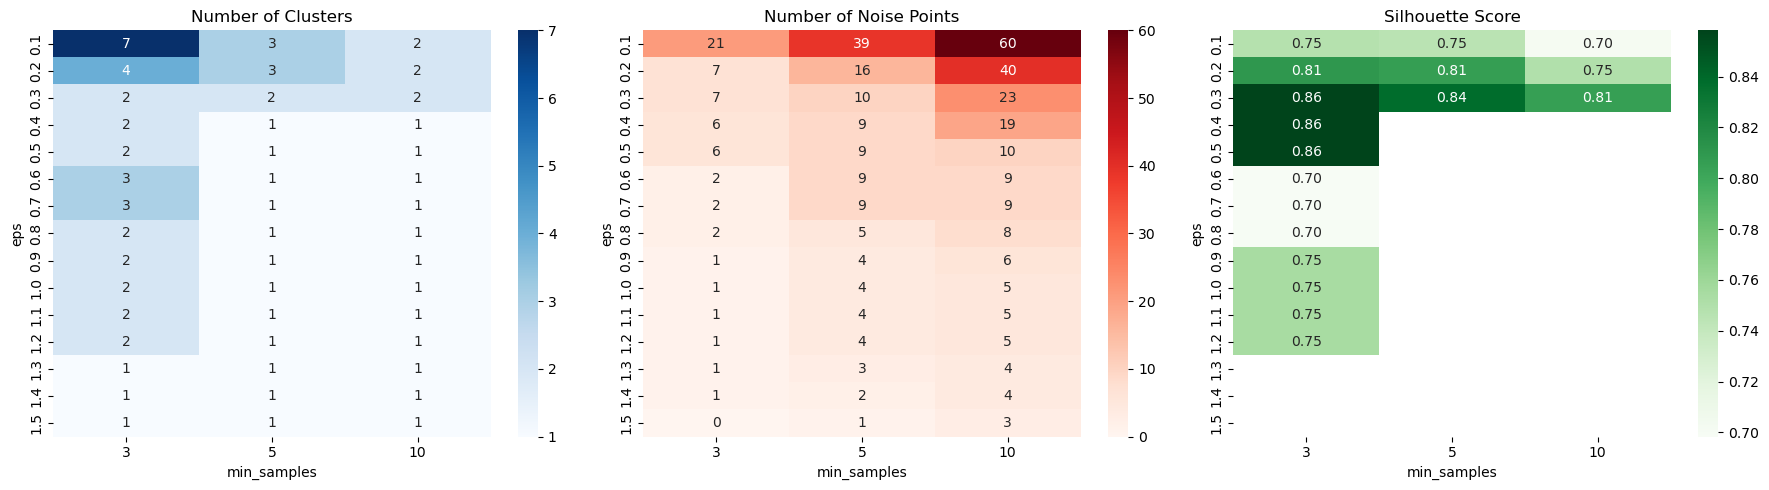

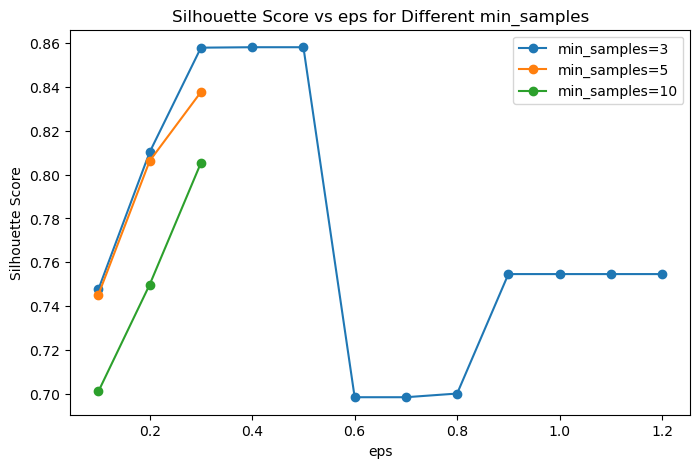

In [213]:
# Pivot results for heatmap visualization
pivot_clusters = results_df.pivot(index='eps', columns='min_samples', values='clusters')
pivot_noise = results_df.pivot(index='eps', columns='min_samples', values='noise')
pivot_silhouette = results_df.pivot(index='eps', columns='min_samples', values='silhouette')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(pivot_clusters, annot=True, fmt='.0f', ax=axes[0], cmap='Blues')
axes[0].set_title('Number of Clusters')
sns.heatmap(pivot_noise, annot=True, fmt='.0f', ax=axes[1], cmap='Reds')
axes[1].set_title('Number of Noise Points')
sns.heatmap(pivot_silhouette, annot=True, fmt='.2f', ax=axes[2], cmap='Greens')
axes[2].set_title('Silhouette Score')
for ax in axes:
    ax.set_xlabel('min_samples')
    ax.set_ylabel('eps')
plt.tight_layout()
plt.show()

# Line plot for silhouette score vs eps for each min_samples
plt.figure(figsize=(8,5))
for min_samples in min_samples_values:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['silhouette'], marker='o', label=f'min_samples={min_samples}')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs eps for Different min_samples')
plt.legend()
plt.show()

Best DBSCAN parameters: eps=0.4, min_samples=3.0, silhouette=0.86


Best DBSCAN parameters: eps=0.4, min_samples=3.0, silhouette=0.86


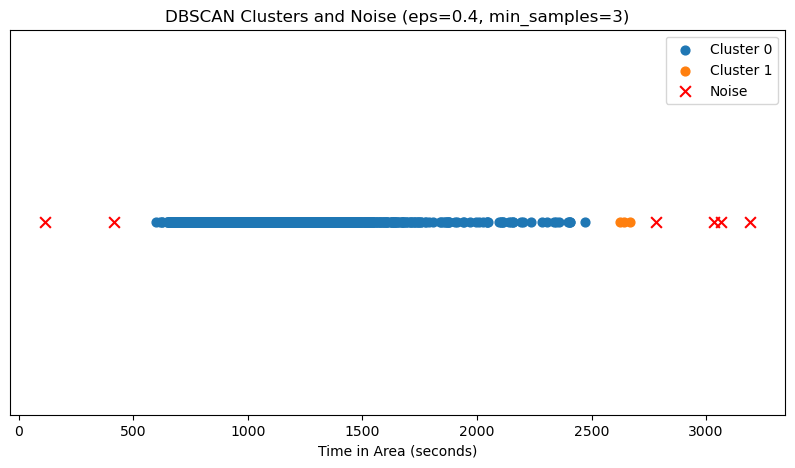

In [214]:
# Find the best parameters (highest silhouette score, ignoring NaN)
best_idx = results_df['silhouette'].idxmax()
best_row = results_df.loc[best_idx]
best_eps = best_row['eps']
best_min_samples = best_row['min_samples']
print(f'Best DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}, silhouette={best_row["silhouette"]:.2f}')

# Run DBSCAN with best parameters
db_best = DBSCAN(eps=best_eps, min_samples=int(best_min_samples)).fit(X_scaled)
labels_best = db_best.labels_

# Plot clusters and noise
plt.figure(figsize=(10, 5))
for label in set(labels_best):
    mask = labels_best == label
    if label == -1:
        plt.scatter(eda_df['time_in_area'][mask], np.zeros(np.sum(mask)), color='red', label='Noise', s=60, marker='x')
    else:
        plt.scatter(eda_df['time_in_area'][mask], np.zeros(np.sum(mask)), label=f'Cluster {label}', s=40)
plt.xlabel('Time in Area (seconds)')
plt.yticks([])
plt.title(f'DBSCAN Clusters and Noise (eps={best_eps}, min_samples={int(best_min_samples)})')
plt.legend()
plt.show()

In [220]:
set(labels_best)

{np.int64(-1), np.int64(0), np.int64(1)}

In [221]:
outlier_indexes = np.where(labels_best == -1)[0]
outlier_indexes

array([ 773, 4558, 4652, 4699, 6352, 6439])

In [223]:
outlier_info = eda_df.iloc[outlier_indexes]
outlier_info

,icao24,date,time_in_area
773,484442,2022-09-17,115.0
4558,48ada5,2022-01-30,3191.0
4652,48ada6,2022-06-23,414.0
4699,48ada6,2022-01-09,2781.0
6352,48af03,2022-02-19,3034.0
6439,8964d3,2022-01-30,3066.0


In [242]:
outlier_flights = []
clustered_flights = {}
for flight in tqdm(traffic):
    if flight.icao24 in outlier_info['icao24'].values and flight.start.date() in outlier_info['date'].values:
        outlier_flights.append(flight)
    else:
        label = cluster_info.loc[(cluster_info['icao24'] == flight.icao24) & (cluster_info['date'] == flight.start.date()), 'label']
        if not label.empty:
            label = label.values[0]
            if label not in clustered_flights:
                clustered_flights[label] = []
            clustered_flights[label].append(flight)

100%|██████████| 6744/6744 [00:30<00:00, 223.88it/s]


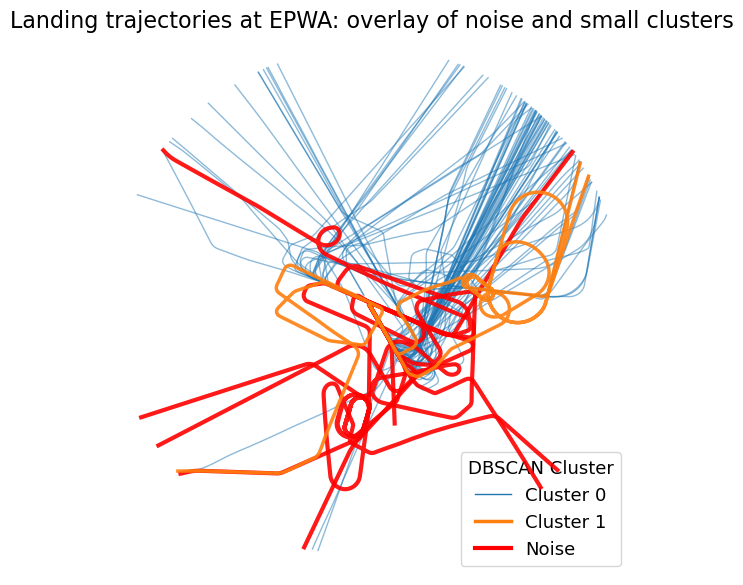

In [243]:
# Overlay noise and small clusters on top of the largest cluster for better visibility
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter

# Count cluster sizes
label_counts = Counter(labels_best)
largest_cluster = max((label for label in label_counts if label != -1), key=lambda l: label_counts[l], default=0)
small_clusters = [label for label, count in label_counts.items() if label != -1 and count < 0.1 * len(labels_best)]  # clusters <10% of data

# Assign colors
unique_labels = set(labels_best)
base_colors = list(mcolors.TABLEAU_COLORS.values())
cluster_colors = {label: base_colors[i % len(base_colors)] for i, label in enumerate(unique_labels) if label != -1}
cluster_colors[-1] = 'red'  # Noise as red

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))
    airports["EPWA"].plot(ax, footprint=False, runways=dict(linewidth=1))

    # Overlay small clusters and noise with thicker lines
    for flight in outlier_flights:
        flight.plot(ax, linewidth=3, color='red', alpha=0.9, zorder=10)
        
    for label in small_clusters:
        for flight in clustered_flights.get(label, []):
            color = cluster_colors.get(label, 'black')
            flight.plot(ax, linewidth=2.5, color=color, alpha=0.9, zorder=10)
            
    # Overlay the largest cluster with a thinner line
    # Plot only a few trajectories from the largest cluster for clarity
    for flight in clustered_flights.get(largest_cluster, [])[:100]:
        color = cluster_colors.get(largest_cluster, 'gray')
        flight.plot(ax, linewidth=1, color=color, alpha=0.5, zorder=5)

    # Add legend for clusters and noise
    handles = [plt.Line2D([0], [0], color=cluster_colors.get(label, 'black'), lw=2.5, label=f"Cluster {label}") for label in small_clusters]
    handles.append(plt.Line2D([0], [0], color='red', lw=3, label="Noise"))
    handles.insert(0, plt.Line2D([0], [0], color=cluster_colors.get(largest_cluster, 'gray'), lw=1, label=f"Cluster {largest_cluster}"))
    ax.legend(handles=handles, title="DBSCAN Cluster")

    ax.set_title("Landing trajectories at EPWA: overlay of noise and small clusters")
plt.show()

# HDBSCAN Clustering

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) is a powerful clustering algorithm that extends DBSCAN by converting it into a hierarchical clustering algorithm and then extracting a flat clustering based on the stability of clusters. It is particularly well-suited for data with clusters of varying densities and is robust to noise and outliers.

In this section, we will:
- Apply HDBSCAN to the standardized trajectory features
- Explore key parameters (`min_cluster_size`, `min_samples`)
- Visualize the resulting clusters and outliers
- Compare HDBSCAN results to DBSCAN


## HDBSCAN Parameters and Initial Results

- **min_cluster_size**: Minimum size of clusters; smaller values allow detection of smaller clusters, larger values yield more robust, larger clusters.
- **min_samples**: Controls how conservative the clustering is with respect to noise; higher values mean more points are labeled as noise.

Next, we will systematically explore these parameters, visualize the resulting clusters and noise, and compare the results to DBSCAN.

In [249]:
min_cluster_sizes = np.arange(5, 31, 5)
min_samples_values = np.arange(3, 16, 2)

hdbscan_results = []

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_values:
        hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = hdb.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        sil = silhouette_score(X_scaled, labels) if n_clusters > 1 else np.nan
        hdbscan_results.append({
            'min_cluster_size': min_cluster_size,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil
        })

hdbscan_results_df = pd.DataFrame(hdbscan_results)
hdbscan_results_df.head()

/home/mstrzezon/miniconda3/envs/traffic/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/mstrzezon/miniconda3/envs/traffic/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/mstrzezon/miniconda3/envs/traffic/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/mstrzezon/miniconda3/envs/traffic/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/mstrzezon/miniconda3/envs/traffic/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all

,min_cluster_size,min_samples,n_clusters,n_noise,silhouette
0,5,3,545,172,0.898305
1,5,5,504,356,0.849915
2,5,7,447,547,0.765790
3,5,9,412,499,0.722614
4,5,11,385,526,0.670184


#### Visualizing HDBSCAN Parameter Effects

To better understand how the choice of `min_cluster_size` and `min_samples` affects clustering results, we visualize:
- Number of clusters
- Number of noise points
- Silhouette score

as a function of the parameters.

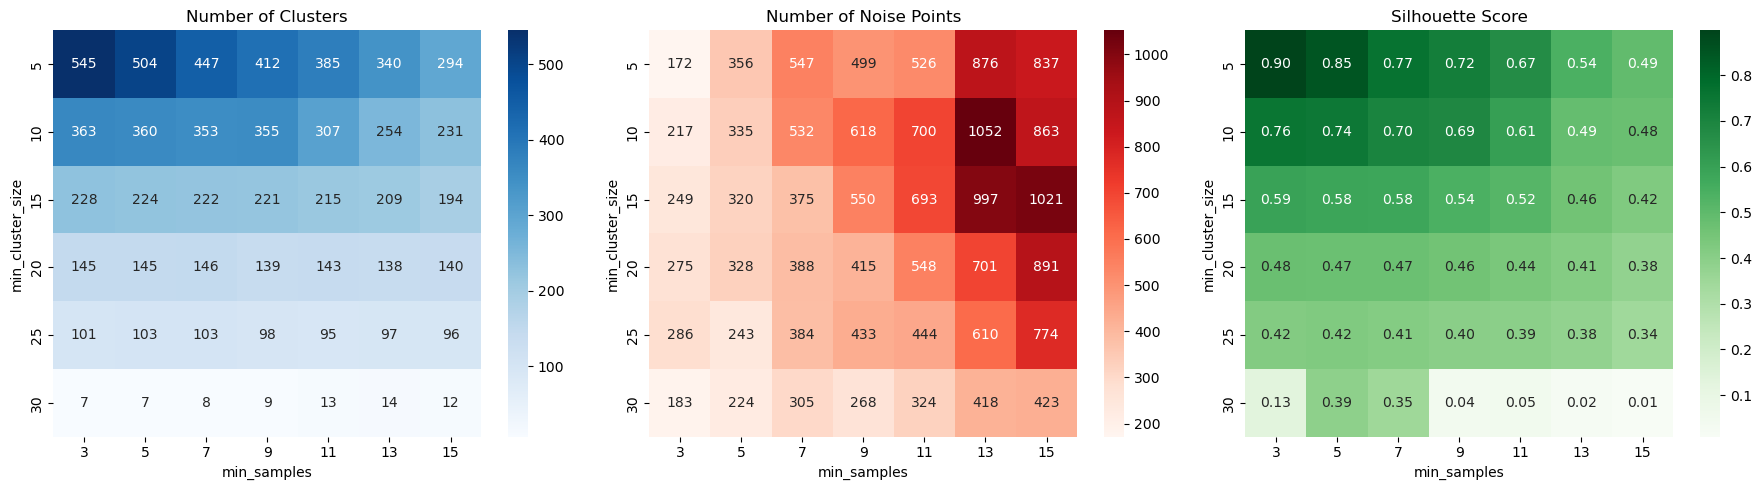

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns

pivot_clusters = hdbscan_results_df.pivot(index='min_cluster_size', columns='min_samples', values='n_clusters')
pivot_noise = hdbscan_results_df.pivot(index='min_cluster_size', columns='min_samples', values='n_noise')
pivot_silhouette = hdbscan_results_df.pivot(index='min_cluster_size', columns='min_samples', values='silhouette')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(pivot_clusters, annot=True, fmt=".0f", ax=axes[0], cmap="Blues")
axes[0].set_title('Number of Clusters')
sns.heatmap(pivot_noise, annot=True, fmt=".0f", ax=axes[1], cmap="Reds")
axes[1].set_title('Number of Noise Points')
sns.heatmap(pivot_silhouette, annot=True, fmt=".2f", ax=axes[2], cmap="Greens")
axes[2].set_title('Silhouette Score')
for ax in axes:
    ax.set_xlabel('min_samples')
    ax.set_ylabel('min_cluster_size')
plt.tight_layout()
plt.show()

#### Selecting Best HDBSCAN Parameters

Based on the above visualizations, select a combination of `min_cluster_size` and `min_samples` that yields a reasonable number of clusters, a manageable amount of noise, and a high silhouette score.

Next, we will visualize the resulting clusters and outliers using these parameters.

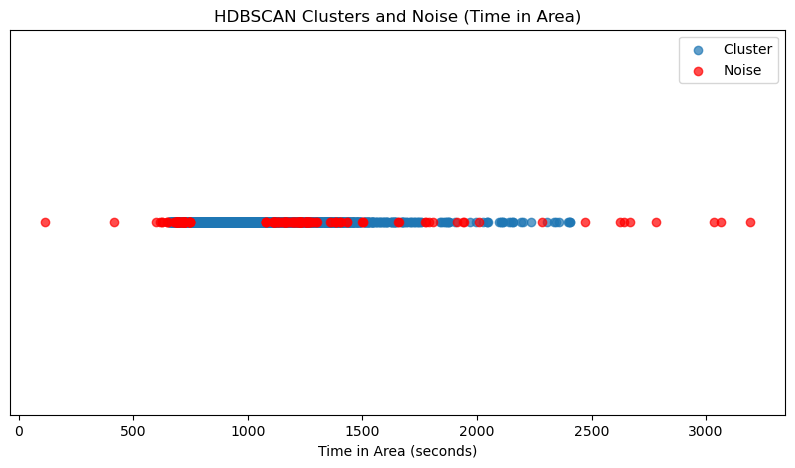

In [252]:
# Visualize HDBSCAN clusters and noise on 'time_in_area'
plt.figure(figsize=(10, 5))
mask_noise = hdb_labels_best == -1
mask_cluster = hdb_labels_best != -1

# Plot all cluster points in one color
plt.scatter(eda_df['time_in_area'][mask_cluster], np.zeros(np.sum(mask_cluster)), 
            color='C0', alpha=0.7, label='Cluster')

# Plot noise points in a different color
plt.scatter(eda_df['time_in_area'][mask_noise], np.zeros(np.sum(mask_noise)), 
            color='red', alpha=0.7, label='Noise')

plt.xlabel('Time in Area (seconds)')
plt.yticks([])
plt.title('HDBSCAN Clusters and Noise (Time in Area)')
plt.legend()
plt.show()

# k-Nearest Neighbors Outlier (kNNO) Detection

The k-Nearest Neighbors Outlier (kNNO) method is a distance-based anomaly detection technique. It identifies outliers by measuring how far each point is from its k nearest neighbors in the feature space. Points with large average distances to their neighbors are considered more likely to be anomalies.

In this section, we will:
- Apply the kNNO method using the anomatool package (or a compatible implementation)
- Explore the effect of the parameter k
- Visualize outlier scores and detected anomalies
- Compare kNNO results to clustering-based outlier detection


In [284]:
knno = kNNO(metric="euclidean")
labels = knno.fit_predict(X_scaled)
scores = knno.predict_proba(X_scaled)[:, 1] 

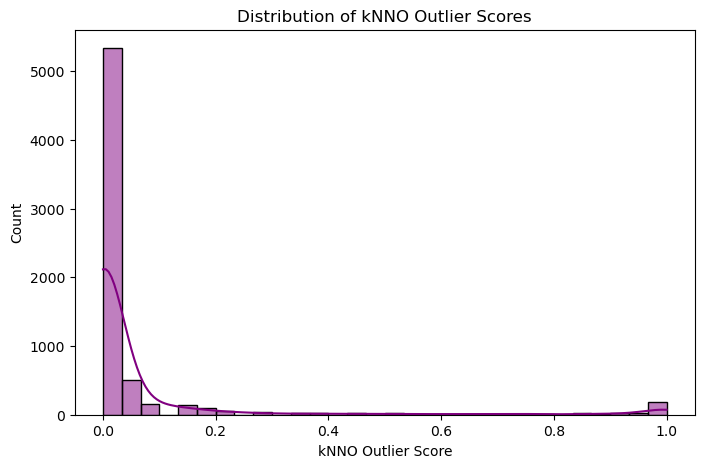

In [285]:
plt.figure(figsize=(8, 5))
sns.histplot(scores, bins=30, kde=True, color='purple')
plt.xlabel('kNNO Outlier Score')
plt.ylabel('Count')
plt.title('Distribution of kNNO Outlier Scores')
plt.show()

In [286]:
# Mark anomalies as those with scores above the 95th percentile
threshold = np.percentile(scores, 95)
anomaly_mask = scores > threshold
anomaly_indexes = np.where(anomaly_mask)[0]

# Show how many anomalies were detected
print(f"Number of anomalies (kNNO, 95th percentile): {len(anomaly_indexes)}")

# Optionally, display the corresponding rows from eda_df
eda_df.iloc[anomaly_indexes]

Number of anomalies (kNNO, 95th percentile): 335


,icao24,date,time_in_area
5,4601f2,2022-10-05,1330.0
18,4601f4,2022-07-15,1628.0
23,4601f4,2022-03-10,1294.0
26,4601f5,2022-05-06,1438.0
27,4601f5,2022-01-02,1509.0
...,...,...,...
6439,8964d3,2022-01-30,3066.0
6518,896530,2022-03-26,1681.0
6546,896532,2022-01-09,1396.0
6677,8965b2,2022-01-28,1512.0


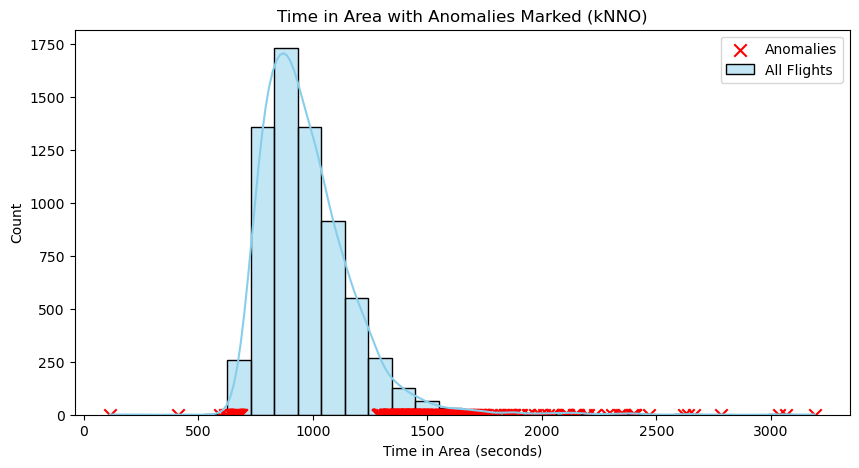

In [287]:
plt.figure(figsize=(10, 5))
sns.histplot(eda_df['time_in_area'], bins=30, kde=True, color='skyblue', label='All Flights')
plt.scatter(eda_df['time_in_area'].iloc[anomaly_indexes], 
            np.zeros_like(anomaly_indexes) - 0.001, 
            color='red', marker='x', s=80, label='Anomalies')
plt.xlabel('Time in Area (seconds)')
plt.title('Time in Area with Anomalies Marked (kNNO)')
plt.legend()
plt.show()

In [293]:
outlier_info = eda_df.iloc[anomaly_indexes]

outlier_flights = []

for flight in tqdm(traffic):
    if flight.icao24 in outlier_info['icao24'].values:
        dates_for_icao = outlier_info[outlier_info['icao24'] == flight.icao24]['date'].values
        if flight.start.date() in dates_for_icao:
            outlier_flights.append(flight)

  0%|          | 0/6744 [00:00<?, ?it/s]

100%|██████████| 6744/6744 [00:16<00:00, 410.66it/s]


In [294]:
len(outlier_flights)

400

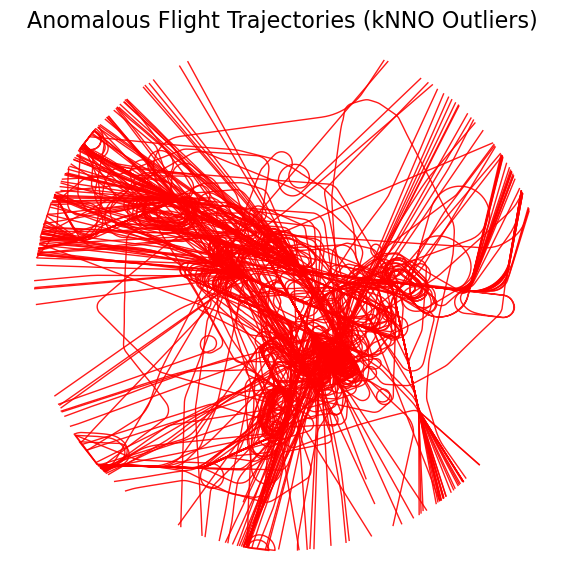

In [296]:
with plt.style.context("traffic"):

    fig, ax = plt.subplots(subplot_kw=dict(projection=EPSG_2180()))
    
    airports["EPWA"].plot(ax, footprint=False, runways=dict(linewidth=1))
    
    for flight in outlier_flights:
        flight.compute_xy(EPSG_2180()).plot(ax, linewidth=1, color='red', alpha=0.9, zorder=10)
    ax.set_title(f"Anomalous Flight Trajectories (kNNO Outliers)")
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.show()